<a href="https://colab.research.google.com/github/aced125/Coulomb_matrix_for_Drug_discovery/blob/master/CoulombNetv1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title
!wget -c https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
!chmod +x Miniconda3-latest-Linux-x86_64.sh
!time bash ./Miniconda3-latest-Linux-x86_64.sh -b -f -p /usr/local
!time conda install -q -y -c conda-forge rdkit

--2019-08-04 21:40:59--  https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
Resolving repo.continuum.io (repo.continuum.io)... 104.18.200.79, 104.18.201.79, 2606:4700::6812:c94f, ...
Connecting to repo.continuum.io (repo.continuum.io)|104.18.200.79|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 75257002 (72M) [application/x-sh]
Saving to: ‘Miniconda3-latest-Linux-x86_64.sh’

Miniconda3-latest-L 100%[===================>]  71.77M   156MB/s    in 0.5s    

2019-08-04 21:41:05 (156 MB/s) - ‘Miniconda3-latest-Linux-x86_64.sh’ saved [75257002/75257002]

PREFIX=/usr/local
Unpacking payload ...
Solving environment: - \ | done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - _libgcc_mutex==0.1=main
    - asn1crypto==0.24.0=py37_0
    - bzip2==1.0.8=h7b6447c_0
    - ca-certificates==2019.5.15=0
    - certifi==2019.6.16=py37_0
    - cffi==1.12.3=py37h2e261b9_0
    - chardet==3.0.4=py37_1
    - conda-packag

In [0]:
import numpy as np
np.random.seed(42)

In [0]:
import sys
import os
sys.path.append('/usr/local/lib/python3.7/site-packages/')

In [4]:
!git clone https://github.com/aced125/RandomMatrixDiscriminant

Cloning into 'RandomMatrixDiscriminant'...
remote: Enumerating objects: 5, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 5 (delta 0), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (5/5), done.


In [5]:
# Imports
import os

# RDkit, a chemoinformatics library
import rdkit
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import PandasTools

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split

import functools

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


import warnings
warnings.filterwarnings('ignore')

import keras


Using TensorFlow backend.


In [0]:
def generate_morgan_matrix(smiles):
    
    # Function that generates the Morgan matrix - can take a couple of minutes
    # for 1000s of molecules
    
    # Input is a pandas Series of SMILES representation of molecules
    
    morgan_matrix = np.zeros((1,2048))
    l = len(smiles)
    
    # Iterate through the compounds
    for i in range(l):
        
        # For each compound, get the structure, convert to Morgan fingerprint,
        # and add to the data matrix
        
        try:
            compound = Chem.MolFromSmiles(smiles[i])
            fp = Chem.AllChem.GetMorganFingerprintAsBitVect(compound, 2, nBits = 2048)
            fp = fp.ToBitString()
            matrix_row = np.array([int(x) for x in list(fp)])
            morgan_matrix = np.row_stack((morgan_matrix, matrix_row))
            
            # Progress checker
            if i%500==0:
                percentage = np.round(100*(i/l),1)
                print(f'{percentage}% done')
        except:
            print(f'problem index:{i}')
    
    # Deleting first row of zeros
    morgan_matrix = np.delete(morgan_matrix, 0, axis = 0)
    
    print('\n')
    print(f'Morgan Matrix dimensions:{morgan_matrix.shape}')
    return morgan_matrix

In [0]:
# Dataset loading functions for ChemBL datasets
def load_dataset(file_name, drop_non_binders = True):
    df = pd.read_csv(file_name, encoding = "ISO-8859-1")
    
    # Converting strings to floats, also set all non-numbers to NaN
    df['Standard Vaue'] = pd.to_numeric(df['Standard Value'],errors = 'coerce')

    # Drop Nans in affinity column
    df.dropna(subset = ['Standard Value'], inplace = True)
    df.reset_index(inplace = True)
    df = df.drop('index',axis = 1)
    
    # Filtering for only activities recorded in nanomolar affinity
    df = df[df['Standard Units'] == 'nM']    

    # Dropping any molecules that don't have a SMILES
    df = df.dropna(subset = ['Canonical Smiles'])
    
    # Considering only the binders (compounds with affinities of less than 1000nM)
    if drop_non_binders:
        df = df[df['Standard Value'] < 1000]
    
    # Dropping duplicate molecules
    df = df.drop_duplicates(subset = 'Canonical Smiles', keep = 'first')
    
    return df

In [0]:
df_train_test = load_dataset('/content/RandomMatrixDiscriminant/adr1b_chembl.csv', False)
df_decoy = load_dataset('/content/RandomMatrixDiscriminant/5ht1a_chembl.csv', drop_non_binders = False)

In [0]:
smiles_train_test = df_train_test['Canonical Smiles']
smiles_train_test = smiles_train_test.reset_index()['Canonical Smiles']
affinity_train_test = df_train_test['Standard Value']

# Making 
binding_threshold = 1000  # units of nM
affinity_train_test_binary = affinity_train_test.apply(lambda x: 1 if x<1000 else 0)

smiles_decoy = df_decoy['Canonical Smiles']
smiles_decoy = smiles_decoy.reset_index()['Canonical Smiles']
affinity_decoy = pd.Series([0 for i in range(len(smiles_decoy))])

In [0]:
affinity_train_test = df_train_test['Standard Value']

In [10]:
Morgan_matrix_train_test = generate_morgan_matrix(smiles_train_test)

0.0% done
30.9% done
61.8% done
92.8% done


Morgan Matrix dimensions:(1617, 2048)


In [0]:
X_train, X_test, y_train, y_test = train_test_split(Morgan_matrix_train_test, affinity_train_test, stratify = affinity_train_test_binary, random_state = 3)


In [13]:
y_test.shape

(405,)

In [0]:
class RMTClassifier(object):
    
    def __init__(self,threshold_multiple = 1, cutoff = 0.95):
        self.cutoff = cutoff
        self.thresh_multiple = threshold_multiple
        

    def _RMT(self, matrix):
        N, p = matrix.shape
        
        gamma = p/N
        thresh = ((1 + np.sqrt(gamma))**2)*self.thresh_multiple
        
        scaler = StandardScaler()
        matrix = scaler.fit_transform(matrix)
        pca = PCA()
        pca.fit_transform(matrix)
        
        # Find significant vector space V
        dim_V = pca.explained_variance_[pca.explained_variance_>thresh].shape[0]
        
        return scaler, pca, dim_V
    
    def _distance_to_projection(self, data, vector_space):
        # Given a vector space, V, we project the data onto that vector space, and then return distance to
        # the original data
        
        # V is formatted such that different vectors are along different columns
        
        # Data matrix is formatted such that rows correspond to different data points
        # and columns correspond to different features
        
        # projected_matrix = D V V.T
        #
        # finally, subtract original data (projectect_matrix - D) take euclidean norm along columns 
        
        # Also note that the vector space can be as large/small as required
        
        return np.linalg.norm( np.dot(data, 
                                      np.dot( vector_space, vector_space.T ) )  - data,
                             axis = 1)
    
    def _distance(self, data, vector_space):
        return np.dot(data, np.dot(vector_space,vector_space.T)) - data
    
    def fit(self, X,y):
        
        # This code is optimized for speed using numpy matrix operations
        X,y = np.array(X), np.array(y)
        actives = X[np.where(y==1)[0],:]
        inactives = X[np.where(y==0)[0],:]
        
        self.scaler_actives, self.pca_actives, self.dim_V_actives = self._RMT(actives)
        self.scaler_inactives, self.pca_inactives, self.dim_V_inactives = self._RMT(inactives)
        
        metric = self.predict_scores(actives)
        
        idx = np.argsort(metric) #sorts in ascending order
        metric = metric[idx]
        cutoff_idx = int(self.cutoff * len(metric))
        self.epsilon = metric[cutoff_idx]

    
    def predict_scores(self, X_test):
        # As described in https://www.pnas.org/content/116/9/3373
        self.scores = (self._distance_to_projection(self.scaler_actives.transform(X_test), 
                                                 self.pca_actives.components_.T[:, :self.dim_V_actives])
                  - 
                  
                 self._distance_to_projection(self.scaler_inactives.transform(X_test), 
                                                 self.pca_inactives.components_.T[:, :self.dim_V_inactives]))
        return self.scores
    
    def projection(self, X):
        return self._distance(self.scaler_actives.transform(X), 
                                                 self.pca_actives.components_.T[:, :self.dim_V_actives])
    
    def predict(self, X_test, epsilon_multiple = 1):
        
        scores = self.predict_scores(X_test)
        predictions = np.array([1 if x<self.epsilon * epsilon_multiple else 0 for x in scores])
        
        return predictions
    
    def return_indices_of_common_molecules_of_active_eig(self, matrix, n=5,eigenvector_index=0):
        
        # returns molecules that lie closest to the selected eigenvector
        # default number of molecules returned = 5
        
        # Pick out the (best) eigenvector
        eig = self.feature_vecs[:,eigenvector_index].reshape(self.p,1)
        
        # Project molecules onto the one-dimensional vector space and get the indices of the top 5 molecules
        # https://stackoverflow.com/questions/6910641/how-do-i-get-indices-of-n-maximum-values-in-a-numpy-array
        return np.argpartition(    np.dot(matrix, eig).reshape(matrix.shape[0])   , -n)[-n:]

In [347]:
clf = RMTClassifier()
clf.fit(X_train, y_train)
test_preds = clf.predict(X_test, epsilon_multiple = 1)
print('confusion_matrix \n',confusion_matrix(y_test, test_preds))
print(classification_report(y_test,test_preds))

ZeroDivisionError: ignored

In [0]:
X_rmt_train = clf.projection(X_train)
X_rmt_test = clf.projection(X_test)

In [0]:
from __future__ import print_function

import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import RMSprop

In [0]:
batch_size = 128
num_classes = 2
epochs = 20


In [764]:
X_rmt_train = X_rmt_train.astype('float32')
X_rmt_test = X_rmt_test.astype('float32')
X_rmt_test.shape, y_test.shape

((405, 2048), (405,))

In [15]:
y_train[:5]

2016     4329.0
762     10000.0
395       300.0
168       250.0
416       160.0
Name: Standard Value, dtype: float64

In [0]:
y_train = keras.utils.to_categorical(np.array(y_train), num_classes)
y_test = keras.utils.to_categorical(np.array(y_test), num_classes)

In [0]:
def get_coulomb_matrix(numbers, coords, alpha=1, use_decay=False):
    """
    Generates the unsorted Coulomb-matrix, given that
    """
    top = np.outer(numbers, numbers).astype(np.float64)
    r = cdist(coords, coords)
    if use_decay:
        other = cdist([coords[0]], coords).reshape(-1)
        r += numpy.add.outer(other, other)

    r **= alpha

    with np.errstate(divide='ignore', invalid='ignore'):
        np.divide(top, r, top)
    np.fill_diagonal(top, 0.5 * np.array(numbers) ** 2.4)
    top[top == np.Infinity] = 0
    top[np.isnan(top)] = 0
    return top

In [353]:
mol = Chem.MolFromSmiles(smiles_train_test[0])
mol = Chem.AddHs(mol)
Chem.EmbedMolecule(mol, Chem.ETKDG())

0

In [0]:
}from rdkit.Chem import AllChem as Chem

In [0]:
conf = mol.GetConformer()

In [355]:
z = [atom.GetAtomicNum() for atom in mol.GetAtoms()]
m = np.zeros((mol.GetNumAtoms(),mol.GetNumAtoms()))
z = np.outer(z,z)
z.shape

(61, 61)

In [0]:
smi = smiles_train_test[0]

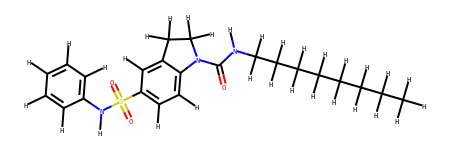

In [78]:
mol = Chem.MolFromSmiles(smi)
mol = Chem.AddHs(mol)
mol

In [81]:
Chem.EmbedMolecule(mol, Chem.ETKDG())

0

In [0]:
conf = molGetConformer()

In [85]:
conf.GetPositions().shape

(61, 3)

In [88]:
mol.GetAtoms()

AttributeError: ignored

In [0]:
from rdkit.Chem import AllChem

In [0]:
def coulomb_generator(smiles):
    matrices = []
    failed_indices = []
    for idx,smile in enumerate(smiles):
        print(idx)
        mol = Chem.MolFromSmiles(smile)
        mol = Chem.AddHs(mol)
        try:
          Chem.EmbedMolecule(mol, Chem.ETKDG())
          conf = mol.GetConformer()
          n_atoms = mol.GetNumAtoms()
          z = np.array([atom.GetAtomicNum() for atom in mol.GetAtoms()])
          xyz = conf.GetPositions()
          m = get_coulomb_matrix(z,xyz)
          
          matrices.append(m)
        
        except:
          print('failed_idx:',idx)
          failed_indices.append(idx)
    
    max_atoms = max([m[0].shape[0] for m in matrices])
    for index, matrix in enumerate(matrices):
        n_atoms = matrix[0].shape[0]
        m = np.zeros((max_atoms, max_atoms))
        m[:n_atoms, :n_atoms] = matrix
        matrices[index] = m
        
    return matrices, failed_indices

In [96]:
cmatrices, failed_indices = coulomb_generator(np.array(smiles_train_test))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

RDKit ERROR: [22:10:12] UFFTYPER: Unrecognized charge state for atom: 6


1035
1036
1037
1038
1039
1040
1041
1042
1043
1044
1045
1046
1047
1048
1049
1050
1051
1052
1053
1054
1055
1056
1057
1058
1059
1060
1061
1062
1063
1064
1065
1066
1067
1068
1069
1070
1071
1072
1073
1074
1075
1076
1077
1078
1079
1080
1081
1082
1083
1084
1085
1086
1087
1088
1089
1090
1091
1092
1093
1094
1095
1096
1097
1098
1099
1100
1101
1102
1103
1104
1105
1106
1107
1108
1109
1110
1111
1112
1113
1114
1115
1116
1117
1118
1119
1120
1121
1122
1123
1124
1125
1126
1127
1128
1129
1130
1131
1132
1133
1134
1135
1136
1137
1138
1139
1140
1141
1142
1143
1144
1145
1146
1147
1148
1149
1150
1151
1152
1153
1154
1155
1156
1157
1158
1159
1160
1161
1162
1163
1164
1165
1166
1167
1168
1169
1170
1171
1172
1173
1174
1175
1176
1177
1178
1179
1180
1181
1182
1183
1184
1185
1186
1187
1188
1189
1190
1191
1192
1193
1194
1195
1196
1197
1198
1199
1200
1201
1202
1203
1204
1205
1206
1207
1208
1209
1210
1211
1212
1213
1214
1215
1216
1217
1218
1219
1220
1221
1222
1223
1224
1225
1226
1227
1228
1229
1230
1231
1232
1233
1234


In [0]:
cmatrices = np.array(cmatrices)
cmatrices_copy = cmatrices.copy()

In [0]:
np.savez_compressed('ADR1B_unsorted_coulomb_matrix',cmatrices)

In [99]:
cmatrices_copy.shape

(1616, 122, 122)

In [0]:
# Failed index = 559

# Dropping failed index

affinity_train_test = affinity_train_test.drop(affinity_train_test.index[failed_indices])

In [133]:
affinity_train_test.shape

(1616,)

In [134]:
# Need to drop

affinity_train_test[affinity_train_test < 0.1]

885     0.000
1831    0.023
2076    0.050
2081    0.050
2209    0.080
2511    0.040
Name: Standard Value, dtype: float64

In [135]:
idx_to_drop = np.where(affinity_train_test.index==885)[0]; idx_to_drop

array([616])

In [0]:
affinity_train_test = affinity_train_test.drop(885)

In [0]:
cmatrices_copy = np.delete(cmatrices_copy, idx_to_drop, axis = 0)

In [141]:
cmatrices_copy.shape

(1615, 122, 122)

In [0]:
# We will try to predict the log binding affinity

log_affinity_train_test = np.log(affinity_train_test)

(array([ 10.,  11.,  37., 136., 165., 311., 370., 364., 154.,  57.]),
 array([-3.77226106, -2.14933642, -0.52641178,  1.09651286,  2.71943751,
         4.34236215,  5.96528679,  7.58821143,  9.21113608, 10.83406072,
        12.45698536]),
 <a list of 10 Patch objects>)

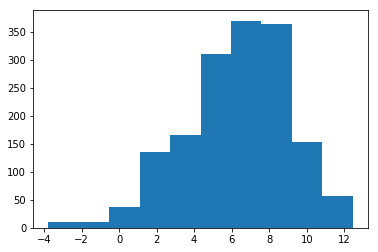

In [145]:
import matplotlib.pyplot as plt
plt.hist(log_affinity_train_test)

In [0]:
def sort_coulomb_matrices(cmatrices_copy):
  ## Function to sort the training matrices
  
  # Get the number of training examples
  n_training_ex = cmatrices_copy.shape[0]
  
  # Get the sorted indices
  idxs = np.linalg.norm(cmatrices_copy, axis = 1).argsort()
  
  # Sort the matrix
  for ex in range(n_training_ex):
    cmatrices_copy[ex] = cmatrices_copy[ex][:,idxs[ex][::-1]][idxs[ex][::-1],:]
    
  return cmatrices_copy

In [0]:
cmatrices_copy = sort_coulomb_matrices(cmatrices_copy)

In [0]:
def generate_flattened_NN_tanh_input(cmatrices_copy, num_thetas=1, theta=1):
  ## As described in 
  ## https://pdfs.semanticscholar.org/5761/d22bb67798167a832879a473e0ece867df04.pdf
  ## pp5.
  
  # Get batch size, and dimensions of matrix (rows should == cols)
  batch_size, dim_rows, dim_cols = cmatrices_copy.shape
  
  # Assert nrows == ncols
  assert dim_rows == dim_cols, 'Input matrix must be square'
  
  # Get size of new mini-vector
  size = 2*num_thetas + 1
  
  # Generate new vector
  arr = np.array([np.tanh(  (cmatrices_copy + theta * v)/theta  ) for v in range(-num_thetas, num_thetas + 1)  ])
  
  # Swap back the batches axis to the first axis
  arr = np.transpose(arr, axes = (1,0,2,3))
  
  # Finally, flatten the array
  arr = arr.reshape(batch_size, size*dim_rows*dim_cols)
  
  return arr

In [862]:
generate_flattened_NN_tanh_input(cmatrices_copy).shape

(1616, 44652)

In [866]:
## Delete the label for the compounds that failed to get a coulomb matrix
failed_indices
modded_affinity_train_test = affinity_train_test.drop(labels = affinity_train_test.index[failed_indices])

[559]

In [0]:
X_train, X_test, y_train, y_test = train_test_split(cmatrices_copy,modded_affinity_train_test,random_state = 3)

In [0]:
y_train = keras.utils.to_categorical(np.array(y_train), num_classes)
y_test = keras.utils.to_categorical(np.array(y_test), num_classes)

In [0]:
def return_noisy_batch_of_coulomb_matrices(cmatrices_copy, sig=1):
  ## Function to return a random batch of coulomb matrices, 
  ## given a batch of sorted/unsorted coulomb matrices.
  
  ## #As described in https://pdfs.semanticscholar.org/5761/d22bb67798167a832879a473e0ece867df04.pdf
  
  # Get the batch size
  batch_size = cmatrices_copy.shape[0]
  
  # Get the dimension of the padded coulomb matrices
  dim_C = cmatrices_copy.shape[1]
  
  # Get the rownorm of the tensor
  rownorm = np.linalg.norm(cmatrices_copy,axis=1)
  
  # Generate some noise
  noise = np.random.normal(0, sig, (batch_size,dim_C))
  
  # Add noise to row norm vector and sort
  noisy_row_norm = rownorm + noise
  noisy_idxs = noisy_row_norm.argsort()
  
  # Reshape the tensor according to the new indices
  for ex in range(batch_size):
    cmatrices_copy[ex] = cmatrices_copy[ex][:,noisy_idxs[ex][::-1]][noisy_idxs[ex][::-1],:]
  
  return cmatrices_copy

In [0]:
import os, pickle, sys, copy, scipy, scipy.io

In [0]:
import numpy as np
from scipy.spatial.distance import cdist

In [0]:
seed = 3453
mb = 25
hist = 0.1

In [0]:
np.random.seed(seed)

In [0]:
dataset = scipy.io.loadmat('/content/qm7.mat')

In [0]:
def get_coulomb_matrix(numbers, coords, alpha=1, use_decay=False):
    """
    Generates the unsorted Coulomb-matrix, given that
    """
    top = np.outer(numbers, numbers).astype(np.float64)
    r = cdist(coords, coords)
    if use_decay:
        other = cdist([coords[0]], coords).reshape(-1)
        r += numpy.add.outer(other, other)

    r **= alpha

    with np.errstate(divide='ignore', invalid='ignore'):
        np.divide(top, r, top)
    np.fill_diagonal(top, 0.5 * np.array(numbers) ** 2.4)
    top[top == np.Infinity] = 0
    top[np.isnan(top)] = 0
    return top

In [21]:
numbers = dataset['Z'];numbers.shape

(7165, 23)

In [22]:
coords = dataset['R']; coords.shape

(7165, 23, 3)

In [24]:
matlist = []
for idx in range(7165):
  if idx%500==0:
    print(idx)
  mat = get_coulomb_matrix(numbers[idx],coords[idx])
  matlist.append(mat)

0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000


In [0]:
matlist = np.array(matlist, dtype = np.float32)

In [26]:
matlist.shape

(7165, 23, 23)

In [0]:
matlist = sort_coulomb_matrices(matlist)

In [0]:
matlist = sort_coulomb_matrices(matlist)
dataset['X'] = sort_coulomb_matrices(dataset['X'])

In [0]:
def sort_coulomb_matrices(cmatrices_copy):
  ## Function to sort the training matrices
  
  # Get the number of training examples
  n_training_ex = cmatrices_copy.shape[0]
  
  # Get the sorted indices
  idxs = np.linalg.norm(cmatrices_copy, axis = 2).argsort()
  
  # Sort the matrix
  for ex in range(n_training_ex):
    cmatrices_copy[ex] = cmatrices_copy[ex][:,idxs[ex][::-1]][idxs[ex][::-1],:]
    
  return cmatrices_copy

In [0]:
sortmat = dataset['X'].copy()

In [0]:
sortmat = sort_coulomb_matrices(sortmat)

In [117]:
dataset['T'][0]

array([ -417.96,  -712.42,  -564.21, ..., -1662.1 , -1782.01, -1919.  ],
      dtype=float32)

In [0]:
class Module:
  def update(self, lr):pass
  def average(self,nn,a):pass
  def backward(self,DY):pass
  def forward(self,X):pass
 

In [0]:
class Sequential(Module):
  def __init__(self,modules):
    self.modules = modules
  
  def forward(self,X):
    for m in self.modules: X=m.forward(X)
    return X
  
  def backward(self,DY):
    for m in self.modules[::-1]: DY = m.backward(DY)
    return DY
  
  def update(self,lr):
    for m in self.modules: X = m.update(lr)
  
  def average(self,nn,a):
    for m,n in zip(self.modules,nn.modules): m.average(n,a)
  

In [0]:
class Input(Module):
  
  def __init__(self,X):
    self.step=1.0
    self.noise=1.0
    self.triuind = (np.arange(122)[:,np.newaxis] <= np.arange(122)[np.newaxis,:]).flatten()
    self.max = 0
    for _ in range(10): 
      self.max=np.maximum(self.max,self.realize(X).max(axis=0))
    X = self.expand(self.realize(X))
    self.nbout = X.shape[1]
    self.mean = X.mean(axis=0)
    self.std = (X - self.mean).std()
    
    
    
    
  def realize(self,X):
    def _realize_(x):
      inds = np.argsort(-(x**2).sum(axis=0)**.5+np.random.normal(0,self.noise,x[0].shape))
      x = x[inds,:][:,inds]*1
      x = x.flatten()[self.triuind]
      return x
    return np.array([_realize_(z) for z in X])
      
  def expand(self,X):
    Xexp = []
    for i in range(X.shape[1]):
      for k in np.arange(0,self.max[i]+self.step,self.step):
        Xexp += [np.tanh((X[:,i]-k)/self.step)]
    return np.array(Xexp).T
  
  def normalize(self,X): return (X-self.mean)/self.std
  
  def forward(self,X): return self.normalize(self.expand(self.realize(X))).astype('float32')

In [0]:
class Output(Module):
  
  def __init__(self,T):
    self.tmean = T.mean()
    self.tstd = T.std()
    self.nbinp = 1
    
  def forward(self,X):
    return X*self.tstd + self.tmean
  
  def backward(self,DY):
    return (DY/self.tstd).astype('float32')[:,np.newaxis]

In [0]:
class Linear(Module):
  
  def __init__(self,m,n):
    
    self.tr = m**.5 / n**.5
    self.lr = 1/m**.5
    
    self.W = np.random.normal(0,1/m**.5,[m,n]).astype('float32')
    self.A = np.zeros([m]).astype('float32')
    self.B = np.zeros([n]).astype('float32')
    
  def forward(self,X):
    self.X = X
    Y = np.dot(X-self.A,self.W) + self.B
    return Y
  
  def backward(self,DY):
    self.DW = np.dot((self.X-self.A).T,DY)
    self.DA = -(self.X-self.A).sum(axis=0)
    self.DB = DY.sum(axis=0)+np.dot(self.DA,self.W)
    DX = self.tr * np.dot(DY,self.W.T)
    return DX
    
  def update(self,lr):
    self.W -= lr*self.lr*self.DW
    self.B -= lr*self.lr*self.DB
    self.A -= lr*self.lr*self.DA
  
  def average(self,nn,a):
    self.W = a*nn.W + (1-a)*self.W
    self.B = a*nn.B + (1-a)*self.B
    self.A = a*nn.A + (1-a)*self.A
  
  

In [0]:
## Linear without A
class Linear(Module):
  
  def __init__(self,m,n):
    
    self.tr = m**.5 / n**.5
    self.lr = 1/m**.5
    
    self.W = np.random.normal(0,1/m**.5,[m,n]).astype('float32')
    self.B = np.zeros([n]).astype('float32')
    
  def forward(self,X):
    self.X = X
    Y = np.dot(X,self.W) + self.B
    return Y
  
  def backward(self,DY):
    self.DW = np.dot((self.X).T,DY)
    self.DB = DY.sum(axis=0)
    DX = self.tr * np.dot(DY,self.W.T)
    return DX
    
  def update(self,lr):
    self.W -= lr*self.lr*self.DW
    self.B -= lr*self.lr*self.DB

  
  def average(self,nn,a):
    self.W = a*nn.W + (1-a)*self.W
    self.B = a*nn.B + (1-a)*self.B

In [0]:
class Sigmoid(Module):
  
  def forward(self,X):
    self.Y = np.tanh(X/1.5)
    return 1.5*self.Y
  
  def backward(self,DY):
    return DY*(1-self.Y**2)

In [30]:
P = dataset['P'][list(range(0,1)) + list(range(1+1,5))].flatten(); P.shape

(5732,)

In [31]:
X = matlist[P]; X.shape

(5732, 23, 23)

In [32]:
Ptest = dataset['P'][1]; Ptest.shape

(1433,)

In [33]:
Xtest = matlist[Ptest]; Xtest.shape

(1433, 23, 23)

In [34]:
T = dataset['T'][0,P]; T.shape

(5732,)

In [35]:
Ttest = dataset['T'][0,Ptest]; Ttest.shape

(1433,)

In [0]:
I,O = Input(X),Output(T)

In [42]:
O.nbinp

1

In [0]:
X_train, X_test, y_trakn

In [0]:
nnsgd = Sequential([
    I,
    Linear(I.nbout,400),
    Sigmoid(),
    Linear(400,100),
    Sigmoid(),
    Linear(100,O.nbinp),
    O
])

In [0]:
## Set the weights to the output initialized at 0
nnsgd.modules[-2].W *= 0

In [0]:
nnavg = copy.deepcopy(nnsgd)

In [39]:
for i in range(1,1000001):
  
  # LR schedule
  if i>0:     lr = 0.001
  if i>500:   lr = 0.0025
  if i>2500:  lr = 0.005
  if i>12500: lr = 0.01
    
  r = np.random.randint(0,len(X),[mb])
  Y = nnsgd.forward(X[r])
  nnsgd.backward(Y - T[r])
  nnsgd.update(lr)
  nnavg.average(nnsgd,(1/hist)/((1/hist)+i))
  
  if i%100==0:
    print(i)
    Y = np.array([nnsgd.forward(Xtest) for _ in range(10)]).mean(axis=0)
    print('MAE: %5.2f kcal/mol'%np.abs(Y-Ttest).mean(axis=0))

100
MAE: 101.90 kcal/mol
200
MAE: 67.95 kcal/mol
300
MAE: 55.52 kcal/mol
400
MAE: 46.36 kcal/mol
500
MAE: 41.40 kcal/mol
600
MAE: 34.63 kcal/mol
700
MAE: 31.57 kcal/mol
800
MAE: 29.74 kcal/mol
900
MAE: 29.05 kcal/mol
1000
MAE: 27.11 kcal/mol
1100
MAE: 26.23 kcal/mol
1200
MAE: 24.98 kcal/mol
1300
MAE: 24.89 kcal/mol
1400
MAE: 23.38 kcal/mol
1500
MAE: 22.88 kcal/mol
1600
MAE: 22.18 kcal/mol
1700
MAE: 22.37 kcal/mol
1800
MAE: 21.57 kcal/mol
1900
MAE: 21.08 kcal/mol
2000
MAE: 20.45 kcal/mol
2100
MAE: 20.80 kcal/mol
2200
MAE: 21.07 kcal/mol
2300
MAE: 19.98 kcal/mol
2400
MAE: 19.58 kcal/mol
2500
MAE: 19.60 kcal/mol
2600
MAE: 19.37 kcal/mol
2700
MAE: 19.26 kcal/mol
2800
MAE: 18.81 kcal/mol
2900
MAE: 18.39 kcal/mol
3000
MAE: 17.62 kcal/mol
3100
MAE: 17.69 kcal/mol
3200
MAE: 18.02 kcal/mol
3300
MAE: 17.27 kcal/mol
3400
MAE: 17.13 kcal/mol
3500
MAE: 17.04 kcal/mol
3600
MAE: 16.62 kcal/mol
3700
MAE: 16.54 kcal/mol
3800
MAE: 16.41 kcal/mol
3900
MAE: 16.48 kcal/mol
4000
MAE: 15.94 kcal/mol
4100
MAE

KeyboardInterrupt: ignored

In [0]:
X_train, X_test, y_train, y_test = train_test_split(cmatrices_copy, np.array(log_affinity_train_test), random_state = 101)

In [155]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1211, 122, 122), (404, 122, 122), (1211,), (404,))

In [0]:
import tensorflow as tf

In [0]:
def randomize(x,y):
  '''
  Randomizes the order of data samples and corresponding labels
  '''
  perm = np.random.permutation(y.shape[0])
  shuffled_x = x[perm]
  shuffled_y = y[perm]
  return shuffled_x, shuffled_y

In [0]:
def get_next_batch(x,y,start,end):
  x_batch = x[start:end]
  y_batch = y[start:end]
  return x_batch, y_batch

In [0]:
tf.reset_default_graph()
init=tf.global_variables_initializer()

In [0]:
# Hyper-parameters
epochs = 1000             # Total number of training epochs
batch_size = 25        # Training batch size
display_freq = 20      # Frequency of displaying the training results
learning_rate = 0.0001   # The optimization initial learning rate
 

In [0]:
def weight_variable(name, shape):
  initer = tf.truncated_normal_initializer(stddev=(1/(shape[0])**.5))
  return tf.get_variable('W_'+name,
                        dtype=tf.float32,
                        shape=shape,
                        initializer=initer)

def bias_variable(name,shape):
  initial = tf.constant(0.,shape=shape,dtype=tf.float32)
  return tf.get_variable('b_'+name,
                        dtype=tf.float32,
                        initializer=initial)

In [0]:
def fc_layer(x,num_units,name,use_sigmoid=True):
  in_dim=x.get_shape().as_list()[1]
  W=weight_variable(name,shape=[in_dim,num_units])
  b=bias_variable(name,[num_units])
  layer=tf.matmul(x,W)
  layer+=b
  if use_sigmoid:
    layer=tf.nn.tanh(layer)
  return layer

In [0]:
I,O = Input(X_train),Output(y_train)

In [243]:
I.nbout

391629

In [0]:
flattened_input_size = I.nbout
n_classes = 1

In [0]:
x = tf.placeholder(tf.float32,shape=[None,flattened_input_size],name='X')
y = tf.placeholder(tf.float32,shape=[None,n_classes],name='Y')

In [0]:
# Computational Graph

fc1 = fc_layer(x,400,'FC1',use_sigmoid=True)
fc2 = fc_layer(fc1,100,'FC2',use_sigmoid=True)
pre_preds = fc_layer(fc2,n_classes,'OUT',use_sigmoid=False)
preds = O.forward(pre_preds)

In [0]:
# Network predictions
#cls_predictions = tf.argmax(output_logits, axis=1, name='predictions')

regression_predictions = preds

loss = tf.losses.mean_squared_error(labels=y,predictions=preds)

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate,name='Adam-op').minimize(loss)
#correct_prediction = tf.equal(tf.argmax(output_logits,1),tf.argmax(y,1),name='correct_pred')
#accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32), name='accuracy')

In [0]:
init=tf.global_variables_initializer()

In [249]:
I.forward(X_train).shape

(1211, 391629)

In [252]:
sess = tf.InteractiveSession()
sess.run(init)

ResourceExhaustedError: ignored

In [250]:
sess = tf.InteractiveSession()
sess.run(init)
global_step=0


num_tr_iter = int(len(X_test) / batch_size)


for epoch in range(epochs):
  print('Training epoch:{}'.format(epoch+1))
  #X_train, y_train = randomize(X_train, y_train)
  
  X_train, y_train = randomize(X_train,y_train)
  
  for iteration in range(num_tr_iter):
    global_step+=1
    
    start = iteration*batch_size
    end = (iteration+1)*batch_size
    
    
    
    x_batch, y_batch = get_next_batch(X_train,y_train,start,end)
    
    
    print(x_batch.shape)
    
    x_batch = I.forward(x_batch)
    
    y_batch = y_batch[:,np.newaxis]
    
    
    # Generate noisy coulomb batch
    #x_batch = return_noisy_batch_of_coulomb_matrices(x_batch,sig = 10)
    
    # Convert into the binary-like flattened input
    #x_batch = generate_flattened_NN_tanh_input(x_batch,theta = 5)
    
    
    # Run optimization operation
    feed_dict_batch = {x:x_batch, y:y_batch}
    sess.run(optimizer,feed_dict=feed_dict_batch)
    
    if iteration%display_freq==0:
      # Calculate and display batch loss and accuracy
      loss_batch = sess.run(loss,feed_dict={x:x_batch,y:y_batch})
      
      print("iter {0:3d}:\t Loss={1:.2f}".
                  format(iteration, loss_batch))
  
  save_path = saver.save(sess, "model.ckpt")
  print("Model saved in path: %s" % save_path)
  #X_test_validation = generate_flattened_NN_tanh_input(X_test, theta=5)
  
  #feed_dict_valid = {x:X_test_validation[:1000],y:y_test[:1000]}
  #loss_valid, acc_valid = sess.run([loss,accuracy],feed_dict=feed_dict_valid)
  #print('------------------------------')
  #print('Epoch:{0}, validation loss: {1:.2f}, validation accuracy: {2:.01%}'.
       #format(epoch+1, loss_valid, acc_valid))
  #print('------------------------------')

ResourceExhaustedError: ignored

In [234]:
modxtest = I.forward(X_test)
modytest = y_test.copy()[:,np.newaxis]
print(modxtest.shape,modytest.shape)
feed_dict_test = {x: modxtest, y:modytest}
preds = sess.run(preds, feed_dict = feed_dict_test)

(404, 391638) (404, 1)


InternalError: ignored

In [211]:
np.exp(5)

148.4131591025766

In [179]:
preds.reshape(-1).shape

(404,)

In [180]:
np.array([preds.reshape(-1),modytest.reshape(-1)]).T.shape

(404, 2)

In [182]:
import pandas as pd
results_df = pd.DataFrame(np.array([preds.reshape(-1),modytest.reshape(-1)]).T, columns = ['preds','true']); results_df

,preds,true
0,4.372783,3.784190
1,3.101027,4.605170
2,5.732010,4.941642
3,5.804065,6.363028
4,6.511439,2.532903
5,5.655371,4.143135
6,6.132413,6.677499
7,9.044476,6.286054
8,7.479804,8.612503
9,4.035995,1.098612


In [0]:
preds = np.array(results_df['preds'])
true = np.array(results_df['true'])

In [207]:
thresh = 7
preds_bin = np.array([1 if x < thresh else 0 for x in preds])
true_bin = np.array([1 if x < thresh else 0 for x in true])
from sklearn.metrics import confusion_matrix, classification_report
confusion_matrix(true_bin,preds_bin)

array([[ 87,  68],
       [ 30, 219]])

In [208]:
print(classification_report(true_bin,preds_bin))

              precision    recall  f1-score   support

           0       0.74      0.56      0.64       155
           1       0.76      0.88      0.82       249

    accuracy                           0.76       404
   macro avg       0.75      0.72      0.73       404
weighted avg       0.76      0.76      0.75       404



SyntaxError: ignored